In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.cohort import load_aki_cohort
from src.utils import (
    add_icu_los_days,
    add_dialysis_flag,
    add_early_dopamine_flag,
    add_sofa_score,
    add_sapsii_score,
    add_vasopressor_flags,
    add_mechanical_ventilation_flag,
    add_early_late_dialysis_flags,
    extract_dialysis_timing,              # falls in src.utils vorhanden
    add_dialysis_near_icu_discharge_flag,
    recode_ethnicity,
    add_rrt_persistence_near_discharge,
)

# 1) Load cohort
df_aki = load_aki_cohort()

# 2) Ensure time columns are datetime (super wichtig!)
for c in ["intime", "outtime", "admittime", "dischtime", "deathtime"]:
    if c in df_aki.columns:
        df_aki[c] = df_aki[c].astype("datetime64[ns]")

# 3) Add baseline / outcomes
df_aki = add_icu_los_days(df_aki)

# 4) Dialysis "ever" flag (pragmatic; ICD + MV)
df_aki = add_dialysis_flag(df_aki)

# 5) SOFA + interventions
df_aki = add_sofa_score(df_aki)
df_aki = add_sapsii_score(df_aki)
df_aki = add_mechanical_ventilation_flag(df_aki)

# 6) Vasopressors / dopamine early flags
df_aki = add_vasopressor_flags(df_aki, window_hours=24)
df_aki = add_early_dopamine_flag(df_aki, window_hours=24)

# 7) Ethnicity grouping
df_aki = recode_ethnicity(df_aki)   # sollte eine neue Spalte wie ethnicity_grp erzeugen

# 8) Timing-aware dialysis (nur MV Events)
df_aki = add_early_late_dialysis_flags(
    df_aki,
    window_hours=24,
    include_inputevents=True,
    allow_negative_hours=False
)

# 9) Optional: Dialysis start/end/duration (falls du die Funktion hast)
# df_aki = extract_dialysis_timing(df_aki)

# 10) Dialysis near ICU discharge (last 6h)
df_aki = add_dialysis_near_icu_discharge_flag(
    df_aki,
    hours_before_discharge=6,
    include_inputevents=True
)
df_aki = extract_dialysis_timing(df_aki)
df_aki = add_rrt_persistence_near_discharge(
    df_aki,
    hours_before_discharge=6
) 

# 11) Quick sanity checks
print("Rows:", len(df_aki))


Rows: 10485


In [3]:
import pandas as pd

def intervention_summary(df, cols):
    out = []
    n = len(df)
    for c in cols:
        if c not in df.columns:
            continue
        s = df[c]
        # robust: falls bool/float/NaN
        x = pd.to_numeric(s, errors="coerce").fillna(0).astype(int)
        out.append({
            "variable": c,
            "n": int(x.sum()),
            "pct": float(x.mean() * 100),
            "missing": int(s.isna().sum()),
        })
    return pd.DataFrame(out).sort_values(["pct","n"], ascending=False)

cols_existing = [
    # dialysis
    "dialysis","dialysis_timed","early_dialysis","late_dialysis","dialysis_icd_only",
    "dialysis_last_6h","rrt_any_in_last6h","rrt_active_at_outtime","rrt_persistent_last6h",
    # ventilation
    "mechanical_ventilation",
    # vasopressors + dopamine
    "any_vasopressor","early_norepinephrine","early_epinephrine","early_phenylephrine","early_dopamine",
]

summary_existing = intervention_summary(df_aki, cols_existing)
print(summary_existing.to_string(index=False))


              variable    n       pct  missing
mechanical_ventilation 4969 47.391512        0
       any_vasopressor 1564 14.916547        0
              dialysis 1386 13.218884        0
  early_norepinephrine 1113 10.615165        0
   early_phenylephrine  796  7.591798        0
     dialysis_icd_only  781  7.448736        0
        dialysis_timed  609  5.808298        0
      dialysis_last_6h  465  4.434907        0
     rrt_any_in_last6h  465  4.434907        0
 rrt_persistent_last6h  441  4.206009        0
        early_dopamine  337  3.214115        0
         late_dialysis  324  3.090129        0
        early_dialysis  285  2.718169        0
     early_epinephrine  135  1.287554        0
 rrt_active_at_outtime   40  0.381497        0


In [4]:
from src.utils import (
    add_early_fluid_flag,
    add_early_diuretic_flag,
)

WINDOW_HOURS = 24  # <- hier anpassen (z.B. 6, 12, 24, 48)

df = df_aki.copy()
df = add_early_fluid_flag(df, window_hours=WINDOW_HOURS)
df = add_early_diuretic_flag(df, window_hours=WINDOW_HOURS)


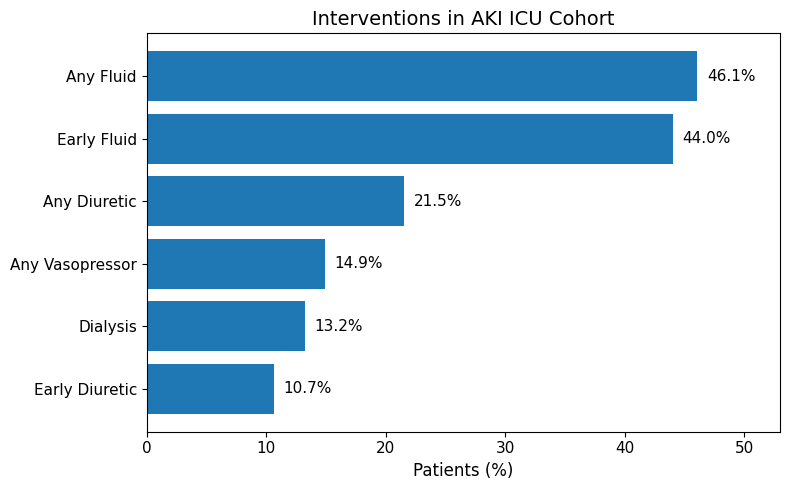

In [9]:
cols = [
    "dialysis",
    "any_vasopressor",
    "early_fluid",
    "any_fluid",
    "early_diuretic",
    "any_diuretic",
]

fig = plot_interventions(
    df,
    cols,
    title="Interventions in AKI ICU Cohort"
)
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_mortality_by_intervention(
    df,
    interventions,
    mortality_col="hospital_mortality",
    figsize=(9, 5),
    title="Hospital Mortality by Intervention Status"
):
    rows = []

    for c in interventions:
        if c not in df.columns:
            continue

        for val, label in [(1, "Yes"), (0, "No")]:
            sub = df[df[c] == val]
            if len(sub) == 0:
                continue

            mort = pd.to_numeric(sub[mortality_col], errors="coerce")
            rows.append({
                "Intervention": c.replace("_", " ").title(),
                "Group": label,
                "Mortality": 100 * mort.mean(),
                "N": len(sub),
            })

    plot_df = pd.DataFrame(rows)

    # Order by mortality in YES group
    order = (
        plot_df[plot_df["Group"] == "Yes"]
        .sort_values("Mortality")["Intervention"]
    )

    fig, ax = plt.subplots(figsize=figsize)

    y = np.arange(len(order))
    width = 0.35

    yes = plot_df[plot_df["Group"] == "Yes"].set_index("Intervention").loc[order]
    no  = plot_df[plot_df["Group"] == "No"].set_index("Intervention").loc[order]

    ax.barh(y - width/2, no["Mortality"], height=width, label="No")
    ax.barh(y + width/2, yes["Mortality"], height=width, label="Yes")

    # --- Labels: % and n
    for i, name in enumerate(order):
        ax.text(
            no.loc[name, "Mortality"] + 0.6,
            i - width/2,
            f'{no.loc[name, "Mortality"]:.1f}%  (n={no.loc[name, "N"]})',
            va="center",
            fontsize=10
        )
        ax.text(
            yes.loc[name, "Mortality"] + 0.6,
            i + width/2,
            f'{yes.loc[name, "Mortality"]:.1f}%  (n={yes.loc[name, "N"]})',
            va="center",
            fontsize=10
        )

    ax.set_yticks(y)
    ax.set_yticklabels(order, fontsize=11)
    ax.set_xlabel("Hospital Mortality (%)", fontsize=12)
    ax.set_title(title, fontsize=14)

    ax.legend(frameon=False)
    ax.set_xlim(0, max(plot_df["Mortality"]) * 1.25)

    plt.tight_layout()
    return fig


In [21]:
df["early_vasopressor"] = (
    (df["early_norepinephrine"] == 1) |
    (df["early_epinephrine"] == 1) |
    (df["early_phenylephrine"] == 1)
).astype(int)
(df["early_vasopressor"] == df["any_vasopressor"]).all()


np.True_

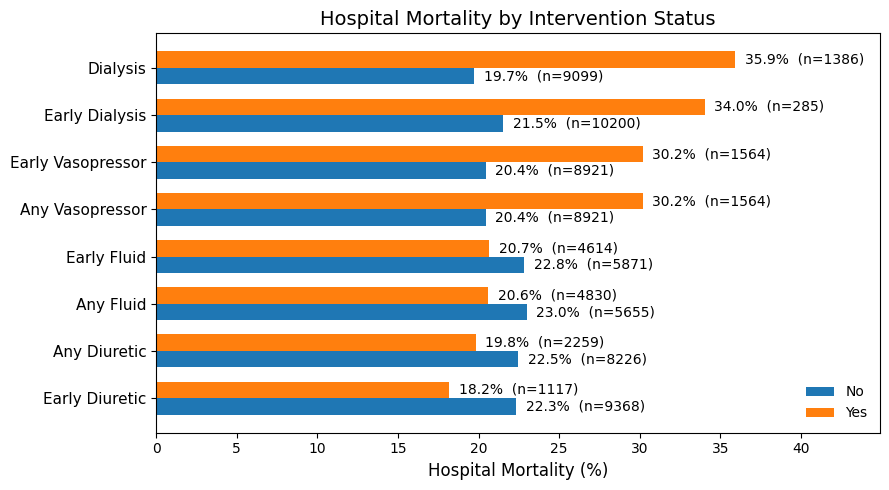

In [22]:
interventions = [
    "dialysis",
    "early_dialysis",
    "any_vasopressor",
    "early_vasopressor",
    "any_fluid",
    "early_fluid",
    "any_diuretic",
    "early_diuretic",

]

fig = plot_mortality_by_intervention(
    df,
    interventions,
    mortality_col="hospital_mortality",
    title="Hospital Mortality by Intervention Status"
)

plt.show()


In [25]:
import pandas as pd
import numpy as np
from src.db import q

def first_intervention_timing(
    df,
    patterns,
    label,
):
    """
    Adds two columns:
      - first_<label>_hours
      - first_<label>_timing  ∈ {0–12 h, 12–24 h, >24 h, No intervention}
    """

    where = " OR ".join([f"LOWER(di.label) LIKE '{p}'" for p in patterns])

    ev = q(f"""
        SELECT ie.icustay_id, ie.starttime
        FROM inputevents_mv ie
        JOIN d_items di ON ie.itemid = di.itemid
        WHERE {where}
    """)

    ev = ev.merge(
        df[["icustay_id", "intime"]],
        on="icustay_id",
        how="inner"
    ).dropna(subset=["starttime", "intime"])

    ev["hours_since_icu"] = (
        ev["starttime"] - ev["intime"]
    ).dt.total_seconds() / 3600

    ev = ev[ev["hours_since_icu"] >= 0]

    first_ev = (
        ev.sort_values(["icustay_id", "hours_since_icu"])
          .groupby("icustay_id", as_index=False)
          .first()[["icustay_id", "hours_since_icu"]]
    )

    out = df.merge(first_ev, on="icustay_id", how="left")

    timing_col = f"first_{label}_timing"
    hours_col = f"first_{label}_hours"

    out[hours_col] = out["hours_since_icu"]

    out[timing_col] = np.select(
        [
            out[hours_col].between(0, 12, inclusive="left"),
            out[hours_col].between(12, 24, inclusive="left"),
            out[hours_col] > 24,
            out[hours_col].isna(),
        ],
        [
            "0–12 h",
            "12–24 h",
            ">24 h",
            "No intervention",
        ],
        default="Other",
    )

    out[timing_col] = pd.Categorical(
        out[timing_col],
        categories=["0–12 h", "12–24 h", ">24 h", "No intervention"],
        ordered=True
    )

    return out.drop(columns=["hours_since_icu"])


In [26]:
VASO_PATTERNS = [
    "%norepinephrine%", "%epinephrine%",
    "%phenylephrine%", "%vasopressin%",
]

FLUID_PATTERNS = [
    "%normal saline%", "%0.9%saline%", "%saline%",
    "%lactated ring%", "%ringer%",
    "%plasmalyte%", "%plasma-lyte%",
    "%d5w%", "%dextrose%",
    "%albumin%",
    "%packed red%", "%prbc%", "%red blood cell%",
    "%fresh frozen plasma%", "%ffp%",
    "%platelet%",
]

DIURETIC_PATTERNS = [
    "%furosemide%", "%lasix%",
    "%bumetanide%", "%torsemide%",
    "%chlorothiazide%", "%metolazone%",
    "%mannitol%", "%acetazolamide%",
]


In [27]:
df3 = df.copy()

df3 = first_intervention_timing(df3, VASO_PATTERNS, "vaso")
df3 = first_intervention_timing(df3, FLUID_PATTERNS, "fluid")
df3 = first_intervention_timing(df3, DIURETIC_PATTERNS, "diuretic")


In [28]:
def mortality_by_timing(df, timing_col, mortality_col="hospital_mortality"):
    out = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mortality_pct=(mortality_col, "mean"),
        )
        .reset_index()
    )
    out["mortality_pct"] *= 100
    return out


In [29]:
mort_vaso = mortality_by_timing(df3, "first_vaso_timing")
mort_fluid = mortality_by_timing(df3, "first_fluid_timing")
mort_diur = mortality_by_timing(df3, "first_diuretic_timing")

mort_vaso, mort_fluid, mort_diur


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


(  first_vaso_timing     n  mortality_pct
 0            0–12 h  1419      29.668781
 1           12–24 h   148      35.135135
 2             >24 h   376      49.734043
 3   No intervention  8542      19.140716,
   first_fluid_timing     n  mortality_pct
 0             0–12 h  4291      21.090655
 1            12–24 h   323      15.170279
 2              >24 h   214      19.158879
 3    No intervention  5657      22.980378,
   first_diuretic_timing     n  mortality_pct
 0                0–12 h   690      19.710145
 1               12–24 h   427      15.690867
 2                 >24 h  1142      21.453590
 3       No intervention  8226      22.453197)

In [30]:
import matplotlib.pyplot as plt

def plot_combined_mortality_by_timing(
    df,
    timing_cols,
    titles,
    mortality_col="hospital_mortality",
    figsize=(12, 4),
):
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    for ax, timing_col, title in zip(axes, timing_cols, titles):
        tmp = (
            df
            .groupby(timing_col)
            .agg(
                n=(mortality_col, "size"),
                mort=(mortality_col, "mean"),
            )
            .reindex(order)
            .reset_index()
        )

        tmp["mort"] *= 100

        ax.bar(
            tmp[timing_col],
            tmp["mort"]
        )

        for i, row in tmp.iterrows():
            if pd.isna(row["mort"]):
                continue
            ax.text(
                i,
                row["mort"] + 0.8,
                f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
                ha="center",
                va="bottom",
                fontsize=11
            )

        ax.set_title(title, fontsize=13)
        ax.set_xlabel("Timing of first intervention", fontsize=11)
        ax.tick_params(axis="x", labelrotation=0, labelsize=11)

    axes[0].set_ylabel("Hospital Mortality (%)", fontsize=12)
    axes[0].set_ylim(0, df[mortality_col].mean() * 200)

    fig.suptitle(
        "Hospital Mortality by Timing of First Intervention",
        fontsize=15,
        y=1.05
    )

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


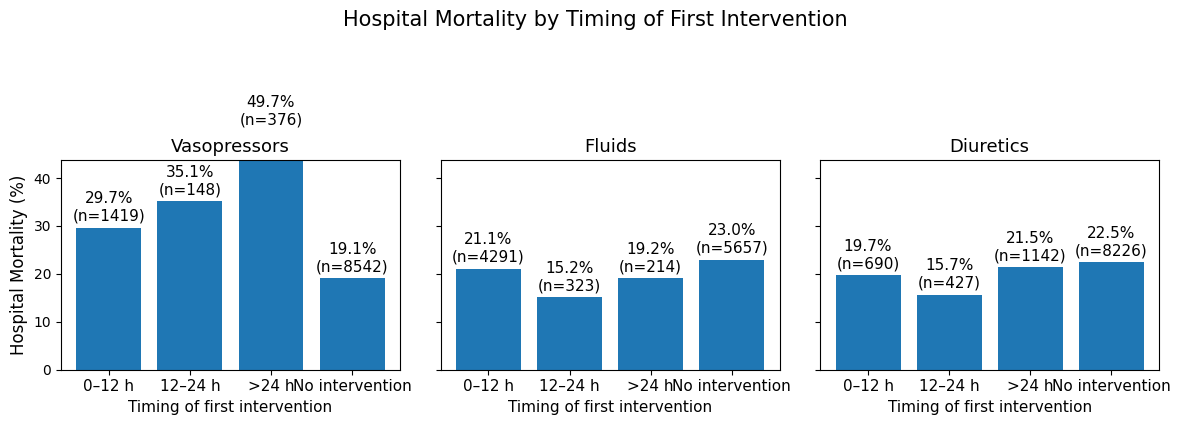

In [31]:
fig = plot_combined_mortality_by_timing(
    df3,
    timing_cols=[
        "first_vaso_timing",
        "first_fluid_timing",
        "first_diuretic_timing",
    ],
    titles=[
        "Vasopressors",
        "Fluids",
        "Diuretics",
    ],
)

plt.show()


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_mortality_by_timing_single(
    df,
    timing_col,
    title,
    mortality_col="hospital_mortality",
    colors=None,
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mort=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mort"],
        color=colors
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mort"]):
            continue
        ax.text(
            i,
            row["mort"] + 0.8,
            f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_ylabel("Hospital Mortality (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.set_title(title, fontsize=14)

    ax.set_ylim(0, max(tmp["mort"].max() * 1.25, 5))
    ax.tick_params(axis="x", labelsize=11)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


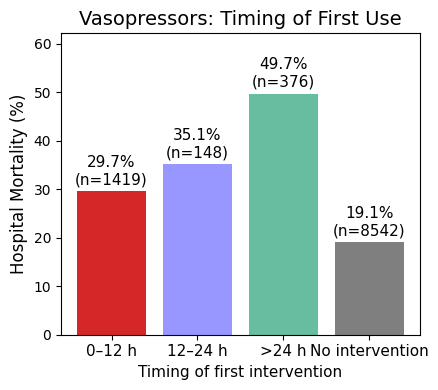

In [34]:
fig_vaso = plot_mortality_by_timing_single(
    df3,
    timing_col="first_vaso_timing",
    title="Vasopressors: Timing of First Use",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


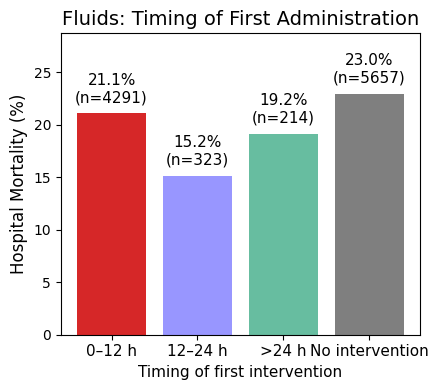

In [36]:
fig_fluid = plot_mortality_by_timing_single(
    df3,
    timing_col="first_fluid_timing",
    title="Fluids: Timing of First Administration",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


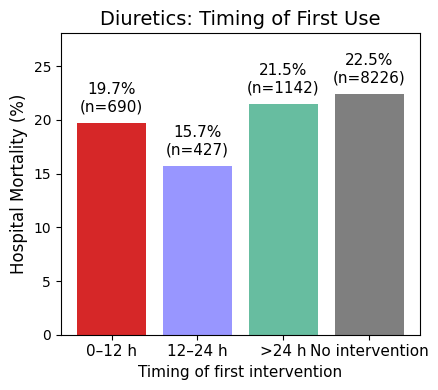

In [38]:
fig_diur = plot_mortality_by_timing_single(
    df3,
    timing_col="first_diuretic_timing",
    title="Diuretics: Timing of First Use",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
    
)

plt.show()


In [39]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_rrt_persistence_by_timing_single(
    df,
    timing_col,
    title,
    outcome_col="rrt_persistent_last6h",
    colors=None,
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(outcome_col, "size"),
            rate=(outcome_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["rate"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["rate"],
        color=colors
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["rate"]):
            continue
        ax.text(
            i,
            row["rate"] + 0.8,
            f'{row["rate"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_ylabel("Persistent RRT at ICU Discharge (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.set_title(title, fontsize=14)

    ax.set_ylim(0, max(tmp["rate"].max() * 1.25, 5))
    ax.tick_params(axis="x", labelsize=11)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


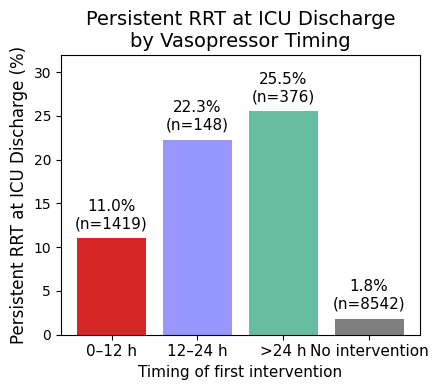

In [44]:
fig_vaso_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_vaso_timing",
    title="Persistent RRT at ICU Discharge\nby Vasopressor Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


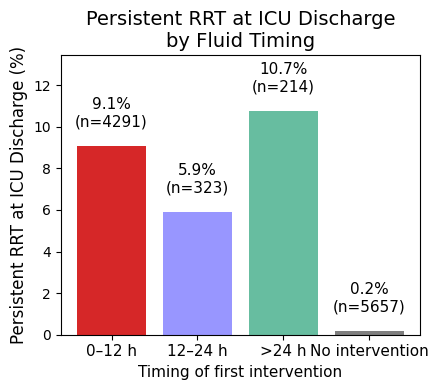

In [45]:
fig_fluid_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_fluid_timing",
    title="Persistent RRT at ICU Discharge\nby Fluid Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


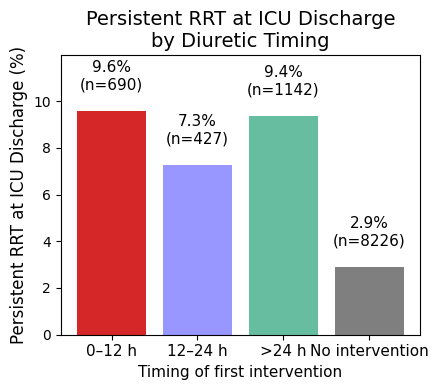

In [47]:
fig_diur_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_diuretic_timing",
    title="Persistent RRT at ICU Discharge\nby Diuretic Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()
